# Compare LSTM - Transfomer

In [2]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
import time
import tensorflow as tf

2022-05-18 09:54:08.694856: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/software/spack/spack-0.11.2/opt/spack/linux-rhel7-x86_64/gcc-5.4.0/openmpi-1.10.7-jdc7f4fjdq5roxhadufd6h66xkwuytss/lib:/usr/local/software/spack/spack-0.11.2/opt/spack/linux-rhel7-x86_64/gcc-4.8.5/gcc-5.4.0-fis24ggupugiobii56fesif2y3qulpdr/lib64:/usr/local/software/spack/spack-0.11.2/opt/spack/linux-rhel7-x86_64/gcc-4.8.5/gcc-5.4.0-fis24ggupugiobii56fesif2y3qulpdr/lib:/usr/local/Cluster-Apps/cuda/8.0/lib64:/usr/local/Cluster-Apps/cuda/8.0/lib:/usr/local/software/global/lib:/usr/local/Cluster-Apps/vgl/2.5.1/64/lib:/usr/local/software/slurm/current/lib
2022-05-18 09:54:08.694923: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [12]:
home_dir = '/home/hpcgies1/Masters-Thesis/AttemptFour/'
eval_dir = f'{home_dir}/Log/'

In [188]:
dirk_metrics = pd.read_csv(f'/home/hpcgies1/Masters-Thesis//postrun_eval_mrcNDO_bs64_embDO3e-1_AdamW1e-5_control.csv')


In [196]:
dirk_metrics = dirk_metrics[['Bleu_1', 'Bleu_2', 'Bleu_3', 'Bleu_4', 'METEOR', 'ROUGE_L', 'CIDEr', 'SPICE']].reindex(range(1, 9)).drop(labels=[3,4,6,8])
dirk_metrics['Subject'] = dirk_metrics.index
cols = dirk_metrics.columns.tolist()
cols = cols[-1:] + cols[:-1]
dirk_metrics = dirk_metrics[cols]
dirk_metrics

,Subject,Bleu_1,Bleu_2,Bleu_3,Bleu_4,METEOR,ROUGE_L,CIDEr,SPICE
1,1,0.547,0.352,0.221,0.140,0.158,0.402,0.388,0.081
2,2,0.512,0.307,0.178,0.107,0.141,0.372,0.278,0.063
5,5,0.499,0.306,0.179,0.106,0.145,0.374,0.285,0.070
7,7,0.493,0.294,0.175,0.108,0.137,0.372,0.270,0.062


In [197]:
sean_metrics = [
    [1, 0.578, 0.392, 0.262, 0.178, 0.176, 0.438, 0.510, 0.097],
    [2, 0.600, 0.412, 0.281, 0.194, 0.180, 0.442, 0.509, 0.102], # correct
    [5, 0.598, 0.411, 0.276, 0.190, 0.182, 0.444, 0.531, 0.110], # fixed 
    [7, 0.596, 0.405, 0.272, 0.184, 0.176, 0.439, 0.509, 0.098], # fixed
]
sean_metrics = pd.DataFrame(sean_metrics, columns=['Subject', 'Bleu_1', 'Bleu_2', 'Bleu_3', 'Bleu_4', 'METEOR', 'ROUGE_L', 'CIDEr', 'SPICE'])
sean_metrics

,Subject,Bleu_1,Bleu_2,Bleu_3,Bleu_4,METEOR,ROUGE_L,CIDEr,SPICE
0,1,0.578,0.392,0.262,0.178,0.176,0.438,0.510,0.097
1,2,0.600,0.412,0.281,0.194,0.180,0.442,0.509,0.102
2,5,0.598,0.411,0.276,0.190,0.182,0.444,0.531,0.110
3,7,0.596,0.405,0.272,0.184,0.176,0.439,0.509,0.098


In [208]:
print("--------------------------------Transformer-------------------------------")
print(dirk_metrics.set_index('Subject'))
print("\n-----------------------------------LSTM-----------------------------------")
print(sean_metrics.set_index('Subject'))

--------------------------------Transformer-------------------------------
         Bleu_1  Bleu_2  Bleu_3  Bleu_4  METEOR  ROUGE_L  CIDEr  SPICE
Subject                                                               
1         0.547   0.352   0.221   0.140   0.158    0.402  0.388  0.081
2         0.512   0.307   0.178   0.107   0.141    0.372  0.278  0.063
5         0.499   0.306   0.179   0.106   0.145    0.374  0.285  0.070
7         0.493   0.294   0.175   0.108   0.137    0.372  0.270  0.062

-----------------------------------LSTM-----------------------------------
         Bleu_1  Bleu_2  Bleu_3  Bleu_4  METEOR  ROUGE_L  CIDEr  SPICE
Subject                                                               
1         0.578   0.392   0.262   0.178   0.176    0.438  0.510  0.097
2         0.600   0.412   0.281   0.194   0.180    0.442  0.509  0.102
5         0.598   0.411   0.276   0.190   0.182    0.444  0.531  0.110
7         0.596   0.405   0.272   0.184   0.176    0.439  0.509  0.0

# Attention maps 

    First 5 test trials for subject 2 attention maps and candidate captions

In [221]:
attn_maps = np.squeeze(np.load(glob.glob(f"{eval_dir}/subject_2_baseline2/eval_out/attention_scores_*.npy")[0]))
print(attn_maps.shape)
output = np.squeeze(np.load(glob.glob(f"{eval_dir}/subject_2_baseline2/eval_out/output_captions_*.npy")[0]))
print(output.shape)

tokenizer = f'{eval_dir}/subject_2_baseline2/eval_out/tokenizer.json'
tokenizer = tf.keras.preprocessing.text.tokenizer_from_json(open(tokenizer, 'r').read())

(515, 15, 360)
(515, 15)


In [258]:
from nsd_access import NSDAccess

keys = pd.read_csv(f'{home_dir}/TrainData/subj02_conditions2.csv')
keys = keys.loc[keys['is_test'] == 1]
print(keys.head())
test_nsd_keys = keys['nsd_key'].values

def init_nsd():
    nsd_loader = NSDAccess('/home/hpcgies1/rds/hpc-work/NIC/NSD/')
    nsd_loader.stim_descriptions = pd.read_csv(nsd_loader.stimuli_description_file, index_col=0)
    print("NSDAccess loader initialized ... ")
    return nsd_loader
nsd_loader = init_nsd()

def get_image(nsd_key):
    return nsd_loader.read_images(int(nsd_key)-1)

     nsd_key  is_shared  is_test
423     3050          1        1
427     3078          1        1
436     3158          1        1
440     3165          1        1
443     3172          1        1
NSDAccess loader initialized ... 


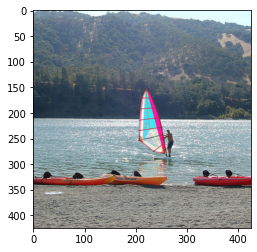

In [245]:
img0 = get_image(3078)
plt.imshow(img0)

In [228]:
captions = tokenizer.sequences_to_texts(output)
captions_clean = []
for cap in captions:
    cap = cap.split(" ")
    cap = [i for i in cap if i != '<end>' and i != '<pad>']
    captions_clean.append(" ".join(cap))


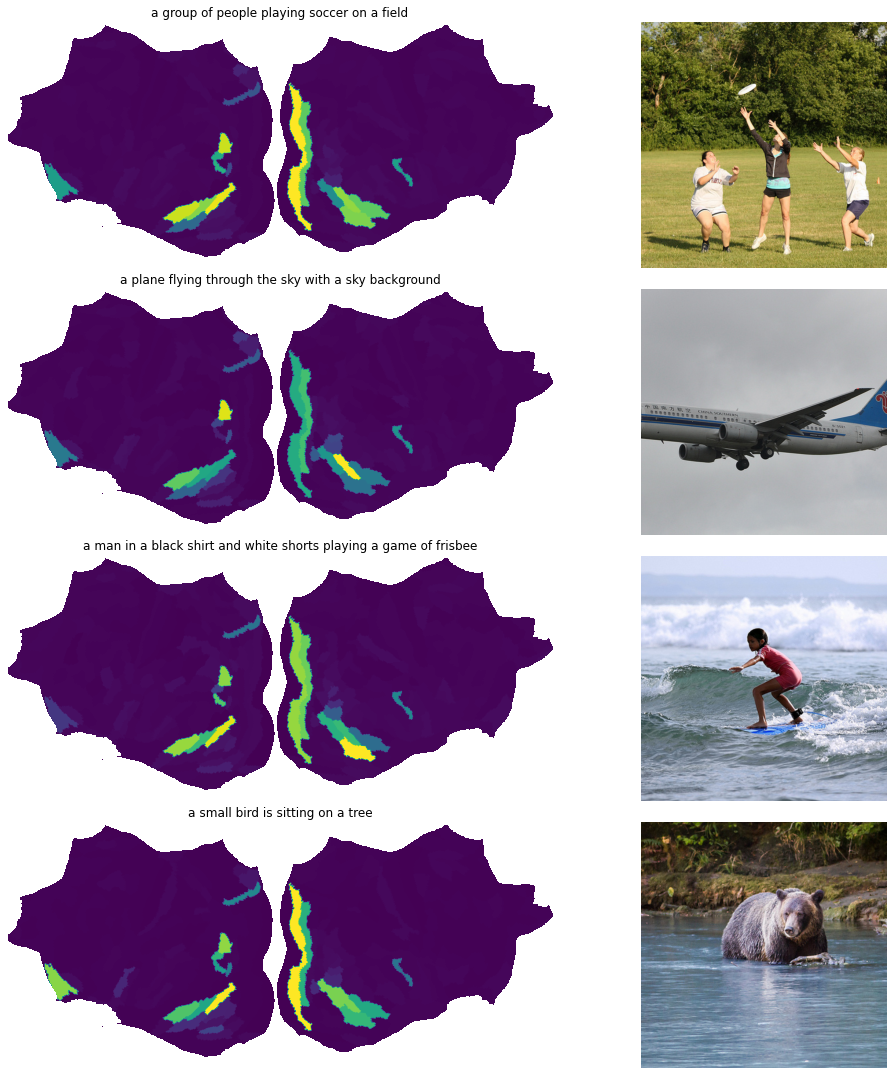

In [283]:
fig, axs = plt.subplots(4,2, figsize=(15,15))

# for i, ax in enumerate(axs.flatten()):
for i, ax in enumerate([0,1,2,3]):
    i += 4
    
    d = np.mean(attn_maps[i], axis=0)
#     d = np.log(d)
    d = get_flatmap(generate_plot(d))[0]
    axs[ax,0].imshow(d)
    axs[ax,0].axis('off')
    axs[ax,0].set_title(captions_clean[i])

for i, ax in enumerate([0,1,2,3]):
    i += 4

    img0 = get_image(test_nsd_keys[i])
    axs[ax,1].imshow(img0)
    axs[ax,1].axis('off')

plt.tight_layout()
plt.savefig(f"{home_dir}/lstm_examples_next4.png", bbox_inches='tight')
plt.show()

In [63]:
f = glob.glob(f"{eval_dir}/subject_2_baseline2/eval_out/*.npy")
for i in f:
    print(i)

/home/hpcgies1/Masters-Thesis/AttemptFour//Log//subject_2_baseline2/eval_out/output_captions_80.npy
/home/hpcgies1/Masters-Thesis/AttemptFour//Log//subject_2_baseline2/eval_out/attention_scores_80_doublecheck.npy
/home/hpcgies1/Masters-Thesis/AttemptFour//Log//subject_2_baseline2/eval_out/attention_scores_80.npy
/home/hpcgies1/Masters-Thesis/AttemptFour//Log//subject_2_baseline2/eval_out/output_guse.npy
/home/hpcgies1/Masters-Thesis/AttemptFour//Log//subject_2_baseline2/eval_out/output_captions_80_doublecheck.npy


In [151]:

sub2 = np.squeeze(np.load('/home/hpcgies1/Masters-Thesis/AttemptFour//Log//subject_2_baseline2/eval_out/attention_scores_80.npy'))
print(sub2.shape)

sub5 = np.squeeze(np.load('/home/hpcgies1/Masters-Thesis/AttemptFour//Log//subject_5_baseline2/eval_out/attention_scores_72.npy'))
print(sub5.shape)

sub7 = np.squeeze(np.load('/home/hpcgies1/Masters-Thesis/AttemptFour//Log//subject_7_baseline2/eval_out/attention_scores_80.npy'))
print(sub7.shape)

(515, 15, 360)
(515, 15, 360)
(515, 15, 360)


In [121]:
import cortex
import nibabel as nb

"""
Load Glasser data
"""

GLASSER_LH = "/rds/user/hpcgies1/hpc-work/NIC/NSD/nsddata/freesurfer/fsaverage/label/lh.HCP_MMP1.mgz"
GLASSER_RH = "/rds/user/hpcgies1/hpc-work/NIC/NSD/nsddata/freesurfer/fsaverage/label/rh.HCP_MMP1.mgz"
s = time.time()
glasser_lh = nb.load(GLASSER_LH).get_fdata() # 163_842 values in the range [0, 180]
glasser_rh = nb.load(GLASSER_RH).get_fdata()
print(f"load glasser masks: {(time.time() - s):.2f}")

glasser = np.vstack((glasser_lh, glasser_rh)).flatten()

print("glasser_lh", glasser_lh.shape)
print("glasser_rh", glasser_rh.shape)
print("glasser   ", glasser.shape)

glasser_lh_flat = glasser_lh.flatten()
glasser_rh_flat = glasser_rh.flatten()
glasser_indices_rh = np.array(range(len(glasser_rh_flat)))
groups_rh = []
for i in set(glasser_rh_flat):
    groups_rh.append(glasser_indices_rh[glasser_rh_flat == i])
glasser_indices_lh = np.array(range(len(glasser_lh_flat)))
groups_lh = []
for i in set(glasser_rh_flat):
    groups_lh.append(glasser_indices_lh[glasser_lh_flat == i])
groups = groups_lh[1:] + groups_rh[1:]
#groups_concat = list(map(list.__add__, groups_lh, groups_rh))
groups_lh = groups_lh[1:]
groups_rh = groups_rh[1:]
assert len(groups) == 360, "Using separate hemishere groups = 360"

def get_flatmap(glasser_regions):
    cortex.add_roi
    vert = cortex.Vertex(glasser_regions, subject='fsaverage')#, vmin=-8, vmax=8)
    im, extents = cortex.quickflat.make_flatmap_image(vert)
    return im, extents

def generate_plot(data_):
    """ Generate the glasser_regions which can be converted to flatmap and plotted 
    Parameters
    ----------
        data : np.array - 1-D  (360,)
    """
    glasser_regions_lh = np.zeros(glasser_lh.shape)
    glasser_regions_rh = np.zeros(glasser_rh.shape)
    glasser_regions_lh[:] = np.NaN
    glasser_regions_rh[:] = np.NaN
    for i, g in enumerate(groups_lh):
        glasser_regions_lh[g] = data_[i]
    for i, g in enumerate(groups_rh):
        glasser_regions_rh[g] = data_[i+180]
    glasser_regions = np.vstack((glasser_regions_lh, glasser_regions_rh)).flatten() # (327684,)
    return glasser_regions

load glasser masks: 0.09
glasser_lh (163842, 1, 1)
glasser_rh (163842, 1, 1)
glasser    (327684,)


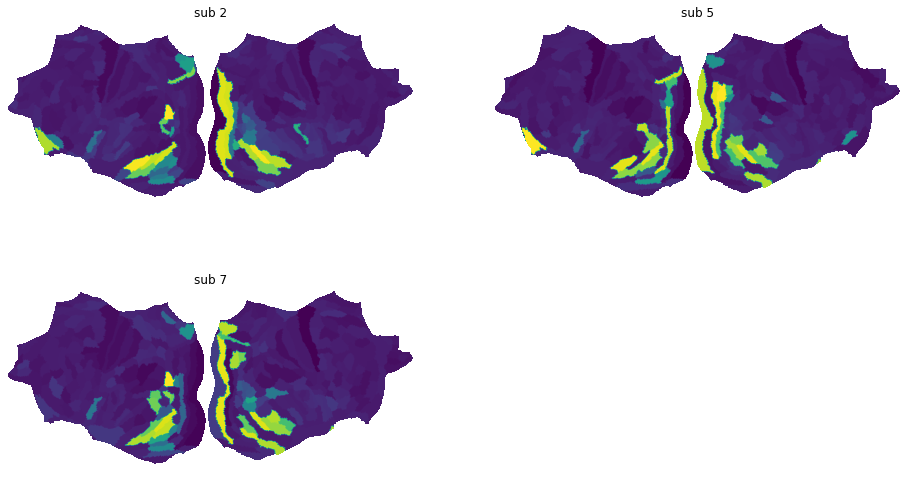

In [159]:

fig, ax = plt.subplots(2,2, figsize=(16,9))

data = [sub2, sub5, sub7]
names = ['sub 2', 'sub 5', 'sub 7']

for i, a in enumerate(ax.flatten()):
    
    try:
        d = get_flatmap(generate_plot(np.mean(data[i], axis=(0,1))))[0]
        a.imshow(np.log(d))
        a.axis('off')
        a.set_title(names[i])
    except IndexError:
        a.axis('off')
plt.show()

In [10]:
loss = pd.read_csv("/home/hpcgies1/rds/hpc-work/NIC/Log/multi_subject_torch2/loss_history.csv")
print(loss['loss'].iloc[275])
# temp = loss.groupby('sub').mean()
# temp.head(26)

3.3688888549804688


In [165]:
loss1 = pd.read_csv("/home/hpcgies1/Masters-Thesis/AttemptFour/Log/multi_subject_torch/torch_loss.csv")
temp = loss1['val_loss'].values
ls = []
for i in temp:
    t = i[1:-1].split(", ")
    t = np.mean(list(map(float, t)))
    ls.append(t)
loss1['val_loss'] = ls
    
temp = loss1['val_accuracy'].values
ls = []
for i in temp:
    t = i[1:-1].split(", ")
    t = np.mean(list(map(float, t)))
    ls.append(t)
loss1['val_accuracy'] = ls
loss1.head()

,Unnamed: 0,sub_0_loss,sub_1_loss,sub_2_loss,sub_3_loss,sub_4_loss,sub_5_loss,sub_6_loss,sub_7_loss,val_loss,val_accuracy
0,0,3.455440,2.754037,2.605094,2.531574,2.439569,2.389656,2.352422,2.337215,2.449912,0.546463
1,1,2.269849,2.228378,2.218987,2.208637,2.172280,2.168466,2.164869,2.176657,2.342907,0.553586
2,2,2.128381,2.110390,2.121240,2.116807,2.091106,2.089773,2.096381,2.112262,2.312299,0.562598
3,3,2.091794,2.077928,2.156283,2.153246,2.068218,2.121013,2.077791,2.151013,2.193429,0.571373
4,4,2.081301,2.069645,2.097652,2.097808,2.058462,2.078848,2.066690,2.109313,2.265554,0.569077
